# Analyze found target nucleotide sequences

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.SeqUtils import GC
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import gget
import random
from dna_features_viewer import GraphicFeature, GraphicRecord

In [2]:
# read gene search results
gene_search_filename = "genes_to_search_22_mar_23_100_reptile_genes_results"
gene_search_file = pathlib.Path(gene_search_filename)
genes_df = pd.read_csv(gene_search_file, index_col=0)
genes_df.reset_index(drop=True, inplace=True)

In [3]:
genes_df = genes_df[:10]

In [4]:
genes_df

,organism_target,organism_with_ortholog,ortholog_ensembl_id,left_neighbor_target,right_neighbor_target,left_neighbor_scaffold_id_target,right_neighbor_scaffold_id_target,nt_seq_target,protein_blast_db,blastx_results
0,anolis_carolinensis,homo_sapiens,ENSG00000069943,ENSACAG00000006873,ENSACAG00000006826,AAWZ02036658.1,AAWZ02037309.1,NaN,NaN,NaN
1,anolis_carolinensis,homo_sapiens,ENSG00000149090,ENSACAG00000004365,ENSACAG00000005180,1,1,TTACAGTTCCCTGACACAAACTGAGTTGATCAGAGTCTCACTTTGC...,anolis_carolinensis_ENSG00000149090.fasta,anolis_carolinensis_ENSG00000149090.out
2,anolis_carolinensis,homo_sapiens,ENSG00000169604,ENSACAG00000037210,ENSACAG00000037210,AAWZ02038318.1,AAWZ02038318.1,NaN,NaN,NaN
3,pelodiscus_sinensis,homo_sapiens,ENSG00000155229,ENSPSIG00000007380,ENSPSIG00000007380,JH206457.1,JH206457.1,NaN,NaN,NaN
4,pelodiscus_sinensis,homo_sapiens,ENSG00000072952,ENSPSIG00000007284,ENSPSIG00000006368,JH206164.1,JH210139.1,NaN,NaN,NaN
5,pelodiscus_sinensis,homo_sapiens,ENSG00000136010,ENSPSIG00000016866,ENSPSIG00000016709,JH224648.1,JH224648.1,CAGCAATACTATTTCACAACAGGATCTGCAGGTGCAATACTGGAGA...,pelodiscus_sinensis_ENSG00000136010.fasta,pelodiscus_sinensis_ENSG00000136010.out
6,pelodiscus_sinensis,homo_sapiens,ENSG00000092439,ENSPSIG00000018029,ENSPSIG00000008469,JH224677.1,JH212494.1,NaN,NaN,NaN
7,anolis_carolinensis,homo_sapiens,ENSG00000167972,ENSACAG00000013796,ENSACAG00000001657,GL343827.1,GL343621.1,NaN,NaN,NaN
8,pelodiscus_sinensis,homo_sapiens,ENSG00000117408,ENSPSIG00000013770,ENSPSIG00000012991,JH211923.1,JH209937.1,NaN,NaN,NaN
9,anolis_carolinensis,homo_sapiens,ENSG00000151148,ENSACAG00000011719,ENSACAG00000011719,AAWZ02041607.1,AAWZ02041607.1,NaN,NaN,NaN


## Target sequence characteristics (GC%, N%)

In [5]:
# get GC% for found target areas (ideally gene sequences, but we do not have those yet)
def get_gc_percentage(seq: str):
    gc_p = GC(seq)
    gc_p = np.round(gc_p, 1)
    return gc_p

In [6]:
for i in range(0, len(genes_df.index)):
    if type(genes_df.loc[i, "nt_seq_target"]) == str:
         genes_df.loc[i, "nt_seq_target_GC%"] = get_gc_percentage(genes_df.loc[i, "nt_seq_target"])

In [7]:
# get GC% for found target areas (ideally gene sequences, but we do not have those yet)
def get_n_percentage(seq: str):
    n_c = seq.count("N")
    n_p = n_c / len(seq)
    n_p = np.round(n_p, 1)
    return n_p

In [8]:
for i in range(0, len(genes_df.index)):
    if type(genes_df.loc[i, "nt_seq_target"]) == str:
         genes_df.loc[i, "nt_seq_target_N%"] = get_n_percentage(genes_df.loc[i, "nt_seq_target"])

In [9]:
def get_df_column_mean(col: pd.Series):
    return np.round(col.mean(), 2)

In [10]:
mean_gc = get_df_column_mean(genes_df["nt_seq_target_GC%"])
mean_n = get_df_column_mean(genes_df["nt_seq_target_N%"])

print(f"Mean GC% of target sequence: {mean_gc}")
print(f"Mean N% of target sequence: {mean_n}")

Mean GC% of target sequence: 39.35
Mean N% of target sequence: 0.0


## BLAST hits

In [5]:
protein_libraries = genes_df.loc[genes_df["protein_blast_db"].notna(), "protein_blast_db"].values.tolist()
blastx_out_filenames = genes_df.loc[genes_df["blastx_results"].notna(), "blastx_results"].values.tolist()

In [6]:
outfmt_header = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

In [13]:
# get protein library coverage (% of library proteins from library that have a hit)
for library, result in zip(protein_libraries, blastx_out_filenames):
    records = SeqIO.parse(library, "fasta")
    library_size = len(list(records)) 
    result_df = pd.read_csv(result, sep="\t", header=None, names=outfmt_header)
    results_size = result_df["sseqid"].nunique()
    if results_size == 0:
        coverage = 0
    else:
        coverage = np.round((results_size / library_size) * 100, 2)
    genes_df.loc[(genes_df["protein_blast_db"] == library) & (genes_df["blastx_results"] == result), "library_coverage"] = coverage

In [14]:
# get metrics
highest_bitscores = []
alignment_lengths = []
alignment_percentages = []
all_bitscores = []

for library, result in zip(protein_libraries, blastx_out_filenames):
    result_df = pd.read_csv(result, sep="\t", header=None, names=outfmt_header)
    result_df = result_df[["sseqid", "bitscore", "length"]]

    bitscores = result_df["bitscore"].values.tolist()
    all_bitscores.append(bitscores)
    
    highest_scores = result_df.groupby("sseqid").max()["bitscore"].values.tolist()
    highest_bitscores.append(highest_scores)

    lengths = result_df.groupby("sseqid").sum()["length"].values.tolist()
    alignment_lengths.append(lengths)

    sum_lengths_df = result_df.groupby("sseqid").sum()
    percentages = []
    for i in range(0, len(sum_lengths_df)):
        for record in SeqIO.parse(library, "fasta"):
            if record.id == sum_lengths_df.index[i]:
                protein_len = len(record.seq)
                percentages.append(sum_lengths_df.loc[record.id, "length"] / protein_len)
    alignment_percentages.append(percentages)   

In [15]:
all_bitscores_df = []

for index, lst in enumerate(all_bitscores):
    for item in lst:
        all_bitscores_df.append([index, item])

all_bitscores_df = pd.DataFrame(all_bitscores_df, columns=["Gene", "All bitscores"])

In [16]:
# get metrics bitscores per gene
metrics_per_gene = []

for index, lst in enumerate(highest_bitscores):
    for item in lst:
        metrics_per_gene.append([index, item])

metrics_per_gene_df = pd.DataFrame(metrics_per_gene, columns=["Gene", "Highest bitscores"])

metrics_per_gene_df["Highest bitscores"] = list(np.concatenate(highest_bitscores).flat)
metrics_per_gene_df["Alignment lengths"] = list(np.concatenate(alignment_lengths).flat)
metrics_per_gene_df["Alignment percentages"] = list(np.concatenate(alignment_percentages).flat)

# add library coverage column to metrics dataframe

library_coverages = genes_df.loc[genes_df["library_coverage"].notna(), "library_coverage"].values.tolist()

for i in range(0, metrics_per_gene_df["Gene"].nunique()):
    metrics_per_gene_df.loc[metrics_per_gene_df["Gene"] == i, "Library coverages"] = library_coverages[i]

In [38]:
def scatterplot_per_gene(df: pd.DataFrame, x_axis: str, y_axis: str, x_axis_label: str, y_axis_label: str, title: str, gene_names: list, color: str, alpha = 0.4):
    plt.figure(figsize=(15, 5))
    fig = plt.scatter(data=df, x=x_axis, y=y_axis, s=300, color=color, alpha=alpha)
    plt.title(title, fontsize=15)
    plt.xlabel(x_axis_label, fontsize=15)
    plt.ylabel(y_axis_label, fontsize=15)
    # plt.xticks(df["Gene"].unique().tolist(), rotation=90, labels=gene_names)
    plt.rc("xtick", labelsize=15)
    plt.rc("ytick", labelsize=15) 
    plt.show()

In [39]:
gene_labels = ["PAMR1", "ALDH1L2"] # todo

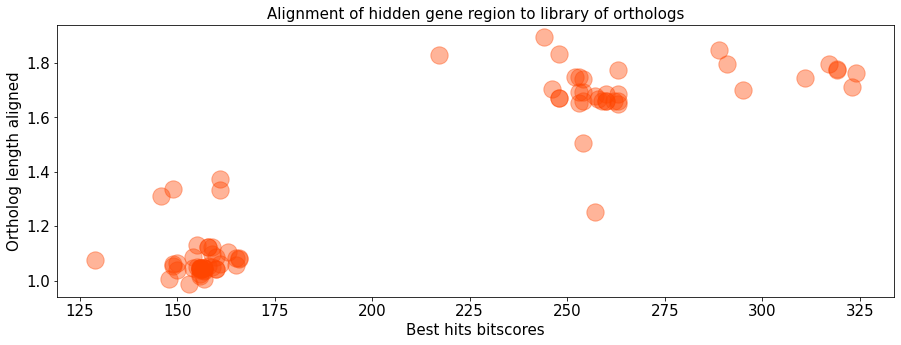

In [44]:
scatterplot_per_gene(metrics_per_gene_df, "Highest bitscores", "Alignment percentages", "Best hits bitscores", "Ortholog length aligned", "Alignment of hidden gene region to library of orthologs", gene_labels, "orangered")

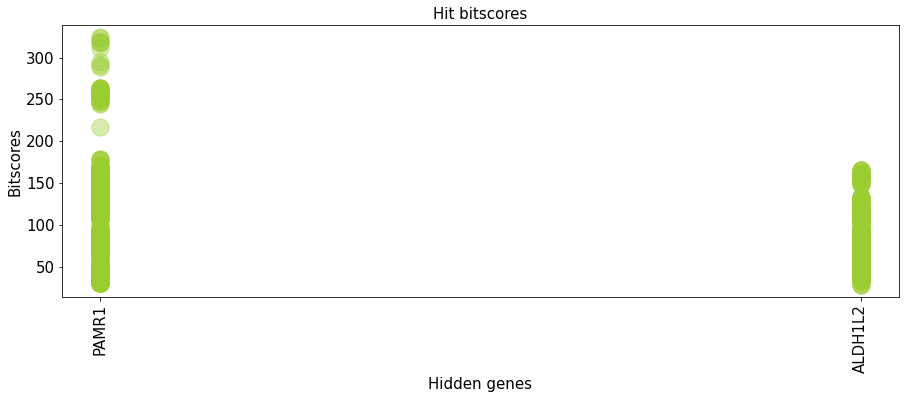

In [29]:
scatterplot_per_gene(all_bitscores_df, "Gene", "All bitscores", "Hidden genes", "Bitscores", "Hit bitscores", gene_labels, "yellowgreen")

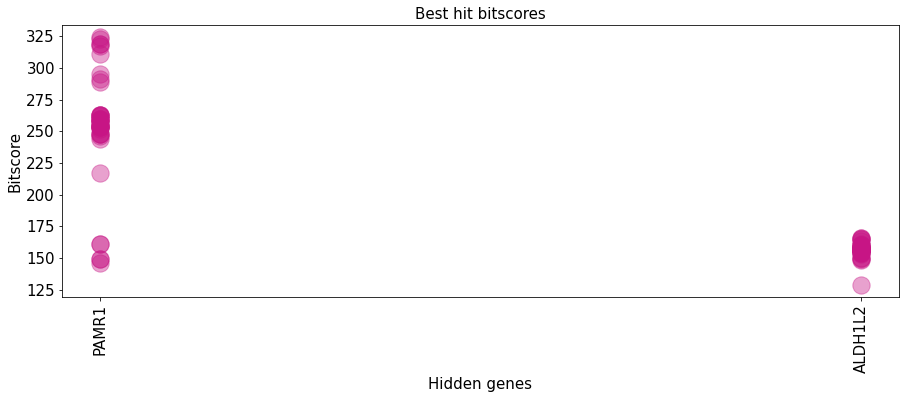

In [30]:
scatterplot_per_gene(metrics_per_gene_df, "Gene", "Highest bitscores", "Hidden genes", "Bitscore", "Best hit bitscores", gene_labels, "mediumvioletred")

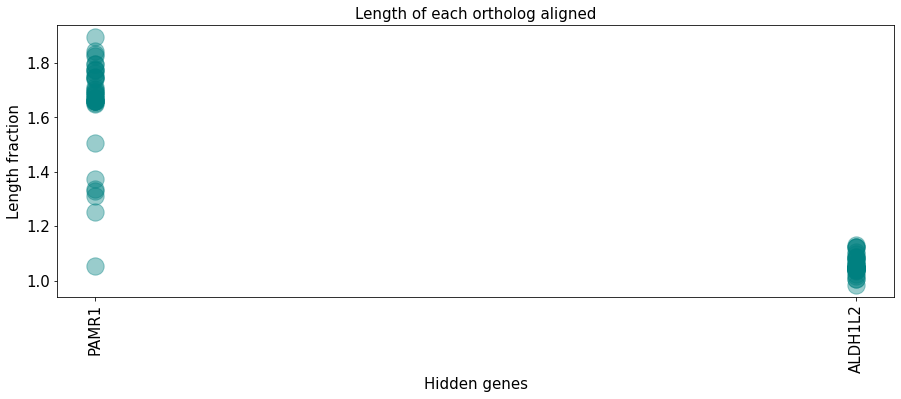

In [31]:
scatterplot_per_gene(metrics_per_gene_df, "Gene", "Alignment percentages", "Hidden genes", "Length fraction", "Length of each ortholog aligned", gene_labels, "teal")

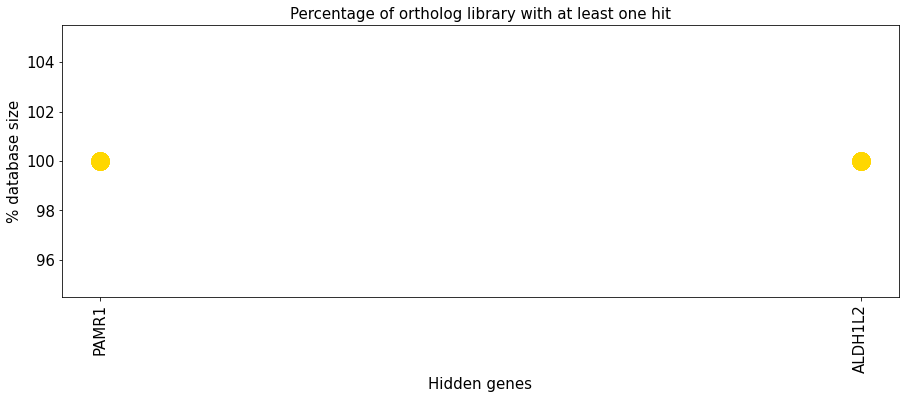

In [32]:
scatterplot_per_gene(metrics_per_gene_df, "Gene", "Library coverages", "Hidden genes", "% database size", "Percentage of ortholog library with at least one hit", gene_labels, "gold")

In [7]:
# found genes dataframe
found_genes = genes_df.loc[genes_df["blastx_results"].notna()].reset_index(drop=True)
found_genes

,organism_target,organism_with_ortholog,ortholog_ensembl_id,left_neighbor_target,right_neighbor_target,left_neighbor_scaffold_id_target,right_neighbor_scaffold_id_target,nt_seq_target,protein_blast_db,blastx_results
0,anolis_carolinensis,homo_sapiens,ENSG00000149090,ENSACAG00000004365,ENSACAG00000005180,1,1,TTACAGTTCCCTGACACAAACTGAGTTGATCAGAGTCTCACTTTGC...,anolis_carolinensis_ENSG00000149090.fasta,anolis_carolinensis_ENSG00000149090.out
1,pelodiscus_sinensis,homo_sapiens,ENSG00000136010,ENSPSIG00000016866,ENSPSIG00000016709,JH224648.1,JH224648.1,CAGCAATACTATTTCACAACAGGATCTGCAGGTGCAATACTGGAGA...,pelodiscus_sinensis_ENSG00000136010.fasta,pelodiscus_sinensis_ENSG00000136010.out


In [63]:
# check if there is any annotated gene in the target sequence area
def get_best_hit_region_coordinates(df):
    for result in df["blastx_results"]:
        result_df = pd.read_csv(result, sep="\t", header=None, names=outfmt_header)
        most_frequent_hit_start = result_df.groupby("sseqid").nth(0)["qstart"].mode().values[0]
        most_frequent_hit_end = result_df.groupby("sseqid").nth(0)["qend"].mode().values[0]
        print(f"fragment coordinates: {most_frequent_hit_start}, {most_frequent_hit_end}")
        region_start_coordinate = int(result_df.loc[0, "qseqid"].split(":")[3])
        hit_region_start = region_start_coordinate + most_frequent_hit_start
        hit_region_end = region_start_coordinate + most_frequent_hit_end
        print(f"scaffold coordinates: {hit_region_start}, {hit_region_end}\n")
             
get_best_hit_region_coordinates(found_genes) # feed the coordinates to Ensembl Biomart

fragment coordinates: 791683, 792216
scaffold coordinates: 54651539, 54652072

fragment coordinates: 91157, 91393
scaffold coordinates: 4043658, 4043894



In [336]:
# genes in the region of the most common hit
# 0 ENSACAG00000041619
# 1 ENSPSIG00000016855

In [8]:
# todo delete after
with open("aldh1l2_tree.txt") as tree_file:
    content = tree_file.read()
    for record in SeqIO.parse(protein_libraries[1], "fasta"):
        try:
            species = gget.info(record.id, verbose=False)["species"].item()
            species = species.replace("_", " ")
            species = species.capitalize()
            print(species)
            content = content.replace(record.id, species)
        except TypeError:
            continue
            
    print(content)

Fri Mar 31 20:53:36 2023 INFO Checking if PDB IDs are available...


Homo sapiens


Fri Mar 31 20:53:48 2023 INFO Checking if PDB IDs are available...


Rattus norvegicus


Fri Mar 31 20:53:58 2023 INFO Checking if PDB IDs are available...


Cavia porcellus


Fri Mar 31 20:54:09 2023 INFO Checking if PDB IDs are available...


Monodelphis domestica


Fri Mar 31 20:54:19 2023 INFO Checking if PDB IDs are available...


Anolis carolinensis


Fri Mar 31 20:54:29 2023 INFO Checking if PDB IDs are available...


Otolemur garnettii


Fri Mar 31 20:54:38 2023 INFO Checking if PDB IDs are available...


Chinchilla lanigera
Ictidomys tridecemlineatus


Fri Mar 31 20:54:54 2023 INFO Checking if PDB IDs are available...


Jaculus jaculus


Fri Mar 31 20:55:03 2023 INFO Checking if PDB IDs are available...


Myotis lucifugus


Fri Mar 31 20:55:12 2023 INFO Checking if PDB IDs are available...


Taeniopygia guttata


Fri Mar 31 20:55:22 2023 INFO Checking if PDB IDs are available...


Ficedula albicollis


Fri Mar 31 20:55:30 2023 INFO Checking if PDB IDs are available...


Chlorocebus sabaeus


Fri Mar 31 20:55:37 2023 INFO Checking if PDB IDs are available...


Nomascus leucogenys


Fri Mar 31 20:55:46 2023 INFO Checking if PDB IDs are available...


Latimeria chalumnae


Fri Mar 31 20:55:55 2023 INFO Checking if PDB IDs are available...


Gadus morhua


Fri Mar 31 20:56:05 2023 INFO Checking if PDB IDs are available...


Oryzias latipes


Fri Mar 31 20:56:14 2023 INFO Checking if PDB IDs are available...


Oreochromis niloticus


Fri Mar 31 20:56:24 2023 INFO Checking if PDB IDs are available...


Xenopus tropicalis


Fri Mar 31 20:56:35 2023 INFO Checking if PDB IDs are available...


Chrysemys picta bellii


Fri Mar 31 20:56:45 2023 INFO Checking if PDB IDs are available...


Gallus gallus


Fri Mar 31 20:56:57 2023 INFO Checking if PDB IDs are available...


Meleagris gallopavo


Fri Mar 31 20:57:06 2023 INFO Checking if PDB IDs are available...


Ornithorhynchus anatinus


Fri Mar 31 20:57:17 2023 INFO Checking if PDB IDs are available...


Sarcophilus harrisii


Fri Mar 31 20:57:27 2023 INFO Checking if PDB IDs are available...


Callithrix jacchus


Fri Mar 31 20:57:35 2023 INFO Checking if PDB IDs are available...


Macaca fascicularis


Fri Mar 31 20:57:47 2023 INFO Checking if PDB IDs are available...


Macaca mulatta


Fri Mar 31 20:57:56 2023 INFO Checking if PDB IDs are available...


Gorilla gorilla
Pan troglodytes


Fri Mar 31 20:58:13 2023 INFO Checking if PDB IDs are available...


Pongo abelii


Fri Mar 31 20:58:23 2023 INFO Checking if PDB IDs are available...


Canis lupus familiaris


Fri Mar 31 20:58:33 2023 INFO Checking if PDB IDs are available...


Ailuropoda melanoleuca


Fri Mar 31 20:58:42 2023 INFO Checking if PDB IDs are available...


Mustela putorius furo


Fri Mar 31 20:58:52 2023 INFO Checking if PDB IDs are available...


Felis catus


Fri Mar 31 20:59:00 2023 INFO Checking if PDB IDs are available...


Loxodonta africana


Fri Mar 31 20:59:15 2023 INFO Checking if PDB IDs are available...


Equus caballus


Fri Mar 31 20:59:24 2023 INFO Checking if PDB IDs are available...


Bos taurus


Fri Mar 31 20:59:36 2023 INFO Checking if PDB IDs are available...


Capra hircus


Fri Mar 31 20:59:44 2023 INFO Checking if PDB IDs are available...


Oryctolagus cuniculus
(
(
(
(
(
(
(
(
(
(
(
Gadus morhua:0.08115,
(
Oryzias latipes:0.04578,
Oreochromis niloticus:0.04493)
:0.01177)
:0.04513,
Xenopus tropicalis:0.06722)
:0.00318,
Latimeria chalumnae:0.09342)
:0.01134,
(
Anolis carolinensis:0.06913,
(
(
(
Ficedula albicollis:0.02903,
Taeniopygia guttata:0.02303)
:0.00471,
(
Gallus gallus:0.01086,
Meleagris gallopavo:0.01305)
:0.02083)
:0.03077,
(
Chrysemys picta bellii:0.01134,
ENSPSIG00000016855:0.07561)
:0.02886)
:0.01096)
:0.01672)
:0.01371,
Ornithorhynchus anatinus:0.04084)
:0.00332,
(
Monodelphis domestica:0.02408,
Sarcophilus harrisii:0.01492)
:0.02753)
:0.02209,
(
(
Cavia porcellus:0.04107,
Chinchilla lanigera:0.03261)
:0.02971,
Rattus norvegicus:0.03313)
:0.00221)
:0.00348,
(
Bos taurus:0.00920,
Capra hircus:0.01356)
:0.01713)
:0.00465,
(
(
(
Loxodonta africana:0.03217,
Ictidomys tridecemlineatus:0.02634)
:0.00103,
Myotis lucifugus:0.01306)
:0.00275,
Equus caballus:0.02028)
:0.00052)
:0.00063,
(
(
Jaculus jaculus:0.03317,
Gor

In [69]:
# PAMR1 ALDH1L2
print(content)